# 實作mini batch gradient desenct

### 釐清到底要用怎麼樣的cost

切batch

In [25]:
%pylab inline
import theano
import theano.tensor as T
#import numpy as np
#import matplotlib.pyplot as plt
import itertools as it

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

### make batches
def mk_batches(x_data, y_data, batch_size, shuffle=False):
    x_batch = list()
    y_batch = list()
    
    x_data_size = x_data.shape[0]
    y_data_size = y_data.shape[0]
    assert x_data_size == y_data_size , 'the x, y dimension is error'
    
    if shuffle:
        indices = np.arange(x_data_size)
        np.random.shuffle(indices)
    
    #range(start, stop, step)
    for start_idx in range(0, x_data_size, batch_size):
        if shuffle:
            idx = indices[start_idx : start_idx + batch_size]            
        else:
            idx = slice(start_idx, start_idx + batch_size)
            
        x_batch.append(x_data[idx])
        y_batch.append(y_data[idx])
    
    return x_batch, y_batch

Populating the interactive namespace from numpy and matplotlib


1. 設定batch size (一個batch要有幾筆資料)
2. create x, y data

In [26]:
### data
batch_size = 10
x_data = floatX(np.array(np.linspace(-5.0, 5.0, 100)))
y_data = floatX(np.array(x_data))

初始化weight，取[0]是為了要一個value而不是array，注意型態

In [27]:
### params / init weights
w = theano.shared(floatX(np.random.randn(1))[0])

定義model

In [28]:
### model
x = T.vector()
y = w*x

## <span style='color:red'>定義cost/error/loss</span>

* 若使用<span style='color:blue'>cost = T.sum((y-y_hat)**2)</span>會遇到的問題是，<span style='color:red'>當batch size有更動時，如10,20,30...，則須配合不同的learning rate，才能接近相同的結果</span>，想一想...，因為假設跑一次的時候用batch size=30算出來的cost和用size=10的cost是有差異的，當然又要用learning rate來調整，update結果才會接近一樣


* 若使用<span style='color:blue'>cost = T.sum((y-y_hat)**2) / batch_size</span>，因為是取平均的概念，對於batch size的調整就不需要再去調learning rate，固定調整一個變數(batch size)就好


* <span style='color:blue'>cost = T.mean((y-y_hat)**2)</span>，這和上面的cost是一樣，這樣寫比較簡潔易懂(我)


* cost/error/loss 回顧，自我解釋
  * gd -> T.sum((y-y_hat)**2) -> 因為是拿全部的資料去做gradient，用sum的概念可能比較直覺吧，全部的誤差(距離)加起來的cost是多少，<span style='color:red'>假如用mean會不會因為training的資料過大，是否被smoothing掉而失真?我想會吧</span>
  * sgd -> (y-y_hat)**2 -> 因為是拿每一筆去做gradient，用squared error比較直覺
  * batch gd -> T.mean((y-y_hat)**2) -> 用平均算比較適合和省事(如上面講的)，適當的batch size也不會太大，而造成取mean後smoothing掉cost結果


* <span style='color:red'>取cost應該了解</span>
  * 訓練model的方式，而不是一昧的照抄別人的程式
  * 你想怎麼測試評估你真實世界的cost/error/loss

In [29]:
### cost/error/loss
y_hat = T.vector()
#cost = T.sum((y-y_hat)**2)
#cost = T.sum((y-y_hat)**2) / batch_size
cost = T.mean((y-y_hat)**2)

定義 gradient

In [30]:
### gradients
def gd(params, grads, lr):
    updates = []
    for p, g in it.izip(params, grads):      
        updates.append([p, p - lr*g])
    return updates
    
dw = T.grad(cost, w)
train = theano.function(inputs=[x, y_hat],
                        outputs=[cost,w],
                        updates=gd([w], [dw], 0.01))

training

In [31]:
# training
costs = []
epochs = 10

for t in range(epochs): 
        all_cost = 0       
        x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
        batch_num = len(x_batches)
        for i in range(batch_num):        
            results = train(x_batches[i], y_batches[i])
            #print 'cost=%f, weight=%f' % (results[0], results[1])        
            costs.append(results[0])
            all_cost += results[0]
        
        print 'batch avg cost=%.5f%%, weight=%f' % (all_cost/batch_num, results[1])      

batch avg cost=0.04172%, weight=1.021722
batch avg cost=0.00099%, weight=1.003426
batch avg cost=0.00002%, weight=1.000594
batch avg cost=0.00000%, weight=1.000079
batch avg cost=0.00000%, weight=1.000012
batch avg cost=0.00000%, weight=1.000002
batch avg cost=0.00000%, weight=1.000000
batch avg cost=0.00000%, weight=1.000000
batch avg cost=0.00000%, weight=1.000000
batch avg cost=0.00000%, weight=1.000000


testing

In [32]:
test = theano.function([x], y)    
y_pre = test(x_data)
print y_pre

[-5.         -4.8989899  -4.7979798  -4.6969697  -4.5959596  -4.4949495
 -4.3939394  -4.2929293  -4.1919192  -4.09090909 -3.98989899 -3.88888889
 -3.78787879 -3.68686869 -3.58585859 -3.48484849 -3.38383839 -3.28282829
 -3.18181818 -3.08080808 -2.97979798 -2.87878788 -2.77777778 -2.67676768
 -2.57575758 -2.47474748 -2.37373738 -2.27272727 -2.17171717 -2.07070707
 -1.96969697 -1.86868687 -1.76767677 -1.66666667 -1.56565657 -1.46464647
 -1.36363636 -1.26262626 -1.16161616 -1.06060606 -0.95959596 -0.85858586
 -0.75757576 -0.65656566 -0.55555556 -0.45454545 -0.35353535 -0.25252525
 -0.15151515 -0.05050505  0.05050505  0.15151515  0.25252525  0.35353535
  0.45454545  0.55555556  0.65656566  0.75757576  0.85858586  0.95959596
  1.06060606  1.16161616  1.26262626  1.36363636  1.46464647  1.56565657
  1.66666667  1.76767677  1.86868687  1.96969697  2.07070707  2.17171717
  2.27272727  2.37373738  2.47474748  2.57575758  2.67676768  2.77777778
  2.87878788  2.97979798  3.08080808  3.18181818  3.

cost

In [33]:
# cost/error/loss
f_cost = theano.function([y, y_hat], cost)
print "testing cost=%.5f%%" % (f_cost(y_pre, y_data))

testing cost=0.00000%


plot cost

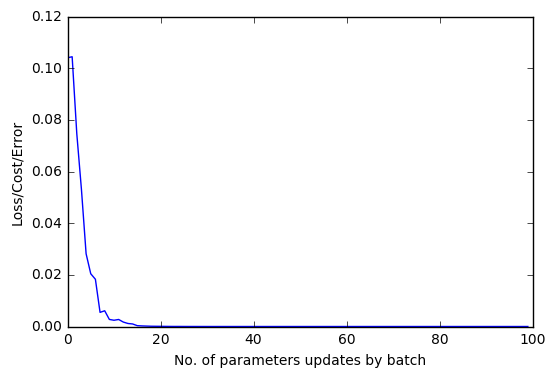

In [34]:
plt.plot(costs)
plt.xlabel("No. of parameters updates by batch")
plt.ylabel("Loss/Cost/Error")
plt.show()